In [1]:
# Import all required modules
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Custom Dataset Loader**

In [2]:
class LeapGestureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}

        folders = sorted(os.listdir(root_dir))
        for idx, folder in enumerate(folders):
            self.label_map[folder] = idx
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                if fname.endswith('.png'):
                    self.image_paths.append(os.path.join(folder_path, fname))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [3]:
import os
# Check directory contents
root = "/kaggle/input/leapgestrecog/leapGestRecog"
print("Top-level folders:", os.listdir(root))

for folder in os.listdir(root):
    folder_path = os.path.join(root, folder)
    print(f"\nChecking folder: {folder}")
    if os.path.isdir(folder_path):
        print("Files inside:", os.listdir(folder_path)[:5])

Top-level folders: ['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']

Checking folder: 07
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 05
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 06
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 02
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 04
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 00
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 08
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 09
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 03
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']

Checking folder: 01
Files inside: ['02_l', '04_fist_moved', '09_c', '10_down', '06_index']


# **Transformations & DataLoader** 

In [4]:
class LeapGestureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}
        label_idx = 0

        # Traverse subject folders
        for subject in os.listdir(root_dir):
            subject_path = os.path.join(root_dir, subject)
            if not os.path.isdir(subject_path):
                continue
            for gesture in os.listdir(subject_path):
                gesture_path = os.path.join(subject_path, gesture)
                if not os.path.isdir(gesture_path):
                    continue
                if gesture not in self.label_map:
                    self.label_map[gesture] = label_idx
                    label_idx += 1
                for fname in os.listdir(gesture_path):
                    if fname.endswith(".png"):
                        self.image_paths.append(os.path.join(gesture_path, fname))
                        self.labels.append(self.label_map[gesture])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [5]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = LeapGestureDataset("/kaggle/input/leapgestrecog/leapGestRecog", transform=transform)
print("Total samples loaded:", len(dataset))  

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

Total samples loaded: 20000


# **CNN Model**

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 10)
model = model.to(device)

# **Training Setup**

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train(model, loader):
    model.train()
    total_loss, correct = 0.0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), correct / len(loader.dataset), all_preds, all_labels

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),                  
    transforms.Grayscale(num_output_channels=3),     
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)            
])

In [9]:
class LeapGestureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}
        label_idx = 0

        for subject in os.listdir(root_dir):
            subject_path = os.path.join(root_dir, subject)
            if not os.path.isdir(subject_path):
                continue
            for gesture in os.listdir(subject_path):
                gesture_path = os.path.join(subject_path, gesture)
                if not os.path.isdir(gesture_path):
                    continue
                if gesture not in self.label_map:
                    self.label_map[gesture] = label_idx
                    label_idx += 1
                for fname in os.listdir(gesture_path):
                    if fname.endswith(".png"):
                        self.image_paths.append(os.path.join(gesture_path, fname))
                        self.labels.append(self.label_map[gesture])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [13]:
dataset = LeapGestureDataset('/kaggle/input/leapgestrecog/leapGestRecog', transform=transform)
print("Loaded dataset size:", len(dataset))

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

Loaded dataset size: 20000


# **Train the Model**

In [14]:
epochs = 15
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc, _, _ = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/15


100%|██████████| 500/500 [00:43<00:00, 11.48it/s]


Train Loss: 1.1314, Train Acc: 0.6134
Test Loss: 0.3113, Test Acc: 0.9062
Epoch 2/15


100%|██████████| 500/500 [00:42<00:00, 11.74it/s]


Train Loss: 0.0923, Train Acc: 0.9788
Test Loss: 0.0297, Test Acc: 0.9932
Epoch 3/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0277, Train Acc: 0.9944
Test Loss: 0.0129, Test Acc: 0.9978
Epoch 4/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0145, Train Acc: 0.9973
Test Loss: 0.0072, Test Acc: 0.9975
Epoch 5/15


100%|██████████| 500/500 [00:42<00:00, 11.76it/s]


Train Loss: 0.0108, Train Acc: 0.9982
Test Loss: 0.0081, Test Acc: 0.9980
Epoch 6/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0080, Train Acc: 0.9984
Test Loss: 0.0150, Test Acc: 0.9945
Epoch 7/15


100%|██████████| 500/500 [00:42<00:00, 11.76it/s]


Train Loss: 0.0122, Train Acc: 0.9968
Test Loss: 0.0065, Test Acc: 0.9980
Epoch 8/15


100%|██████████| 500/500 [00:42<00:00, 11.74it/s]


Train Loss: 0.0057, Train Acc: 0.9988
Test Loss: 0.0300, Test Acc: 0.9910
Epoch 9/15


100%|██████████| 500/500 [00:42<00:00, 11.73it/s]


Train Loss: 0.0028, Train Acc: 0.9996
Test Loss: 0.0019, Test Acc: 0.9995
Epoch 10/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0062, Train Acc: 0.9983
Test Loss: 0.0040, Test Acc: 0.9988
Epoch 11/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0105, Train Acc: 0.9972
Test Loss: 0.0089, Test Acc: 0.9975
Epoch 12/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0038, Train Acc: 0.9991
Test Loss: 0.0024, Test Acc: 0.9990
Epoch 13/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0048, Train Acc: 0.9989
Test Loss: 0.0008, Test Acc: 0.9998
Epoch 14/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0028, Train Acc: 0.9991
Test Loss: 0.0016, Test Acc: 0.9995
Epoch 15/15


100%|██████████| 500/500 [00:42<00:00, 11.75it/s]


Train Loss: 0.0050, Train Acc: 0.9987
Test Loss: 0.0017, Test Acc: 0.9995


In [15]:
_, _, y_pred, y_true = evaluate(model, test_loader)

from sklearn.metrics import accuracy_score

overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\n Overall Test Accuracy: {overall_accuracy * 100:.2f}%")


 Overall Test Accuracy: 99.95%


In [16]:
from sklearn.metrics import classification_report, accuracy_score

# Get predictions after training
_, _, y_pred, y_true = evaluate(model, test_loader)

# Print Classification Report
report = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = accuracy_score(y_true, y_pred)

# Convert report to readable format
import pandas as pd

df_report = pd.DataFrame(report).transpose()
df_report = df_report.rename(index={'accuracy': 'overall_accuracy'})

# Display report
print("Classification Report:")
print(df_report)

# Print only the final overall scores
print("\n Final Scores:")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Precision (macro avg): {report['macro avg']['precision']:.4f}")
print(f"Recall (macro avg): {report['macro avg']['recall']:.4f}")
print(f"F1-Score (macro avg): {report['macro avg']['f1-score']:.4f}")

Classification Report:
                  precision    recall  f1-score    support
0                  1.000000  1.000000  1.000000   417.0000
1                  1.000000  1.000000  1.000000   404.0000
2                  1.000000  1.000000  1.000000   404.0000
3                  1.000000  1.000000  1.000000   418.0000
4                  1.000000  1.000000  1.000000   377.0000
5                  1.000000  1.000000  1.000000   392.0000
6                  1.000000  1.000000  1.000000   403.0000
7                  1.000000  0.995110  0.997549   409.0000
8                  1.000000  1.000000  1.000000   410.0000
9                  0.994565  1.000000  0.997275   366.0000
overall_accuracy   0.999500  0.999500  0.999500     0.9995
macro avg          0.999457  0.999511  0.999482  4000.0000
weighted avg       0.999503  0.999500  0.999500  4000.0000

 Final Scores:
Overall Accuracy: 99.95%
Precision (macro avg): 0.9995
Recall (macro avg): 0.9995
F1-Score (macro avg): 0.9995


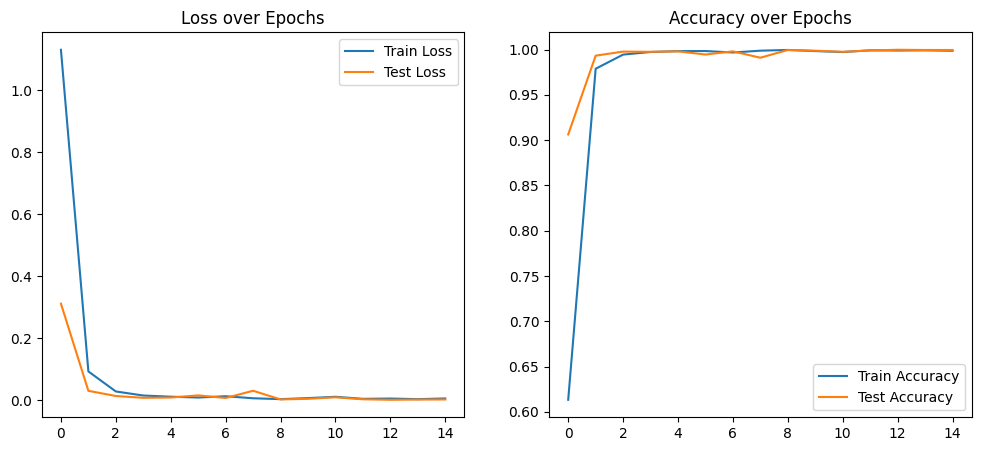

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

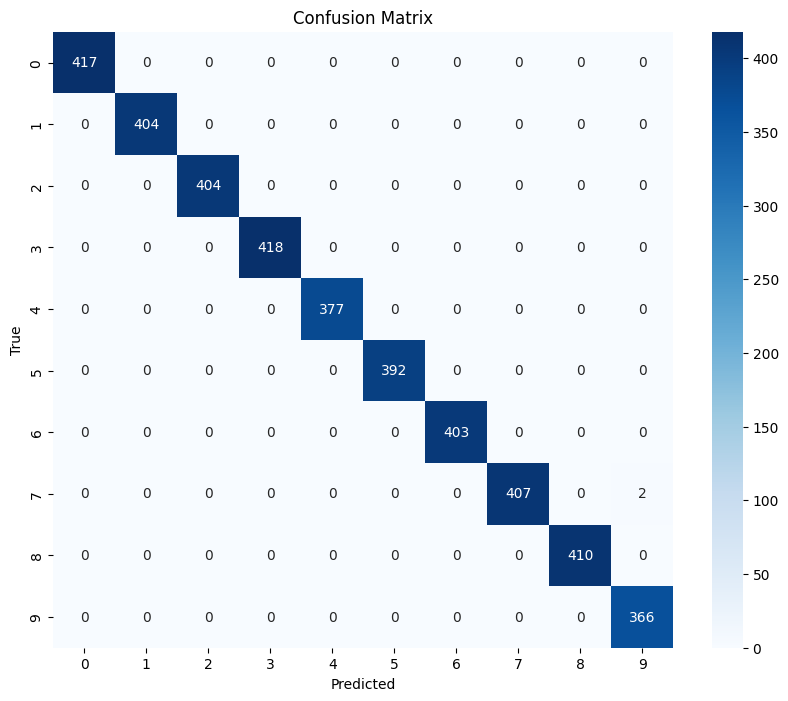

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       1.00      1.00      1.00       404
           2       1.00      1.00      1.00       404
           3       1.00      1.00      1.00       418
           4       1.00      1.00      1.00       377
           5       1.00      1.00      1.00       392
           6       1.00      1.00      1.00       403
           7       1.00      1.00      1.00       409
           8       1.00      1.00      1.00       410
           9       0.99      1.00      1.00       366

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [18]:
_, _, y_pred, y_true = evaluate(model, test_loader)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred))

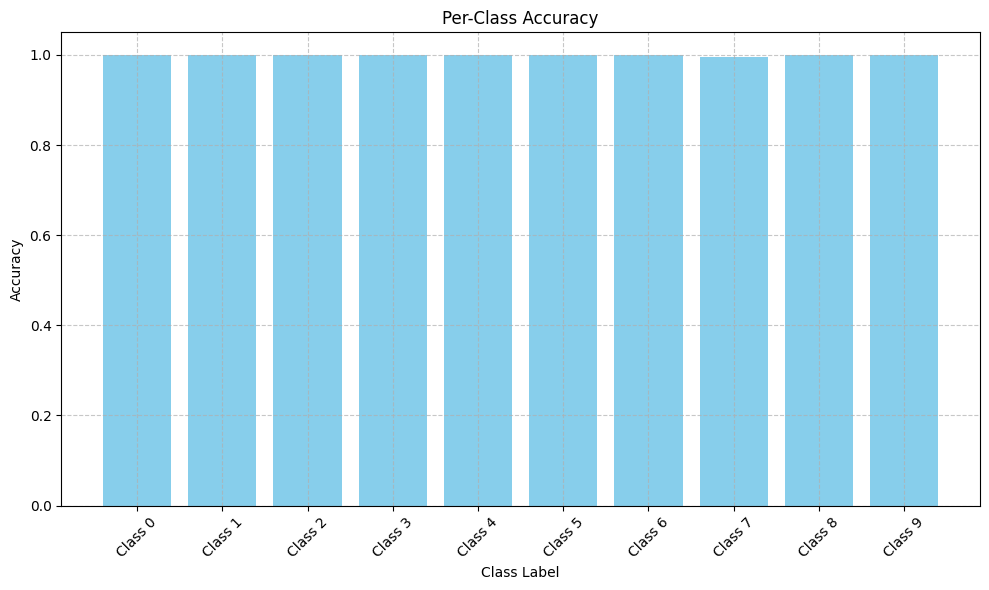

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get class-wise accuracy from confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Plot
plt.figure(figsize=(10,6))
plt.bar(np.arange(len(class_accuracy)), class_accuracy, color='skyblue')
plt.title("Per-Class Accuracy")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.xticks(np.arange(len(class_accuracy)), [f"Class {i}" for i in range(len(class_accuracy))], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

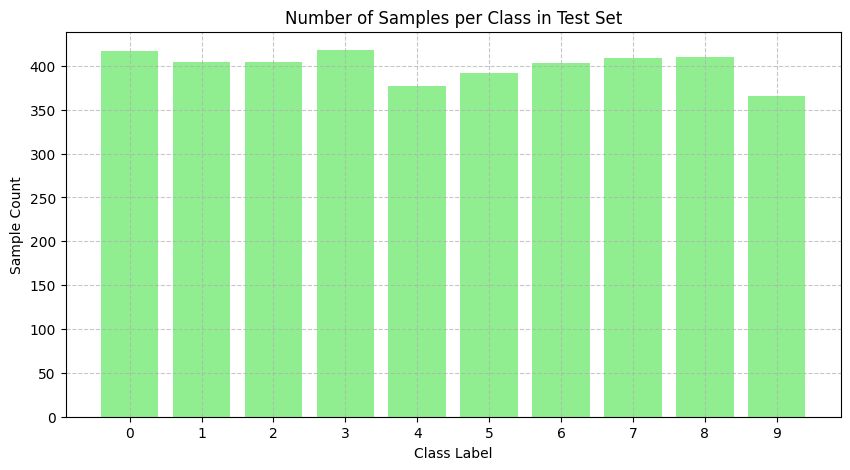

In [20]:
from collections import Counter

class_counts = Counter(y_true)
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.title("Number of Samples per Class in Test Set")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.xticks(list(class_counts.keys()))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<Figure size 1200x500 with 0 Axes>

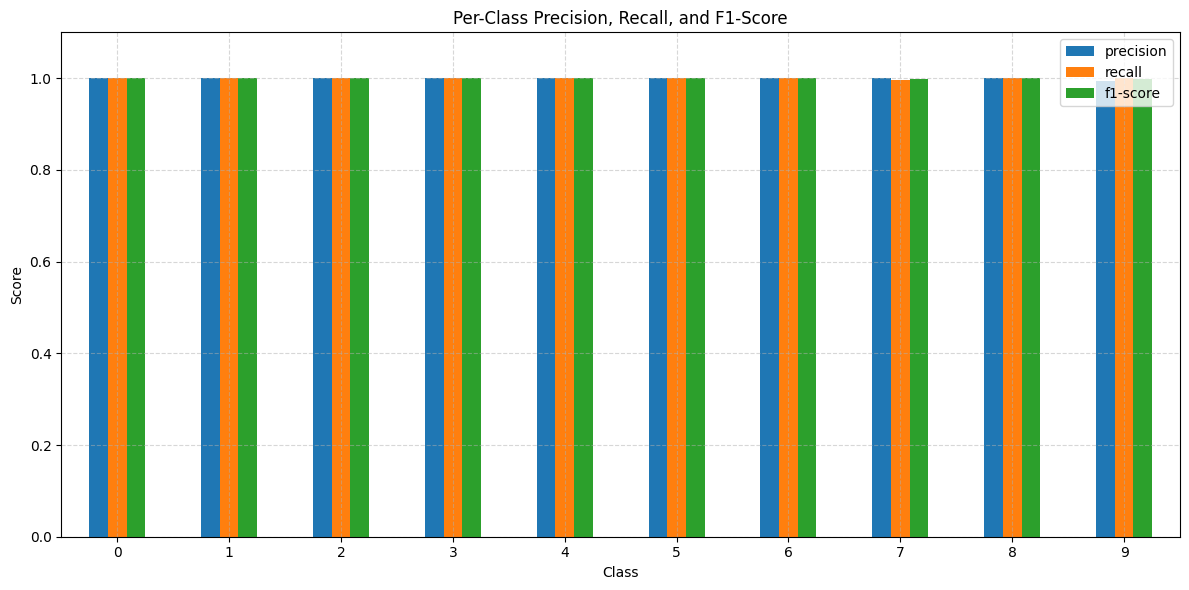

In [21]:
import pandas as pd
report = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

plt.figure(figsize=(12,5))
df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12,6))
plt.title("Per-Class Precision, Recall, and F1-Score")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

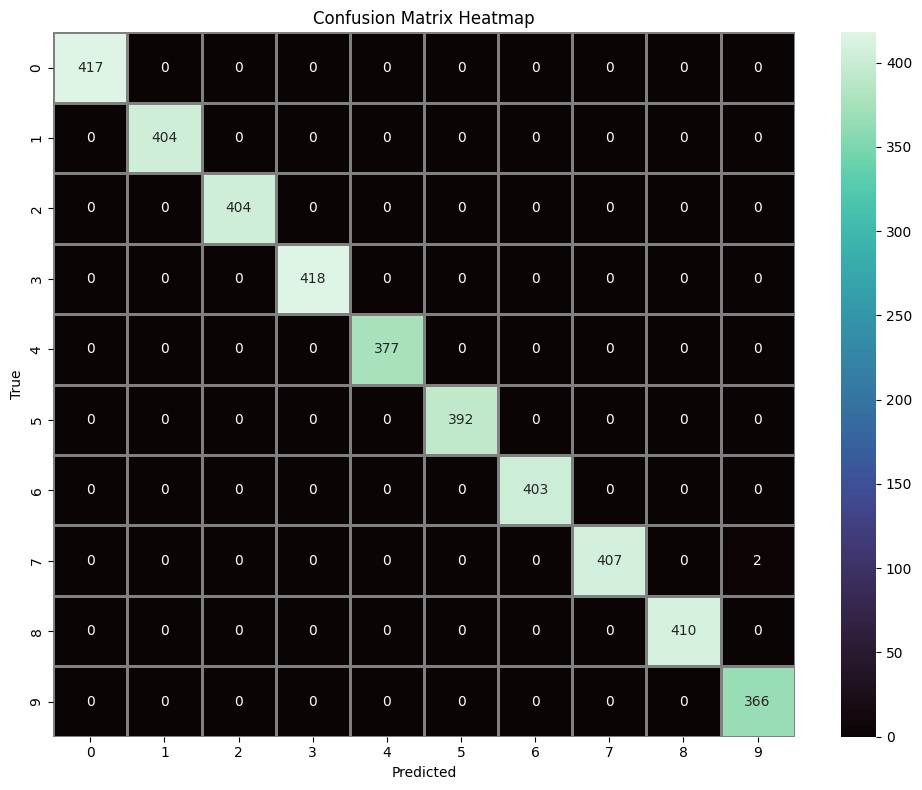

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako', linewidths=1, linecolor='gray')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [23]:
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            out = model.features(inputs)
            out = out.view(out.size(0), -1)
            features.append(out.cpu())
            labels.extend(targets)

    features = torch.cat(features).numpy()
    labels = np.array(labels)
    return features, labels


features, labels = extract_features(model, test_loader)

In [24]:
import umap
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# UMAP to 2D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(features_scaled)

2025-07-22 16:31:28.310162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753201888.493513      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753201888.551368      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


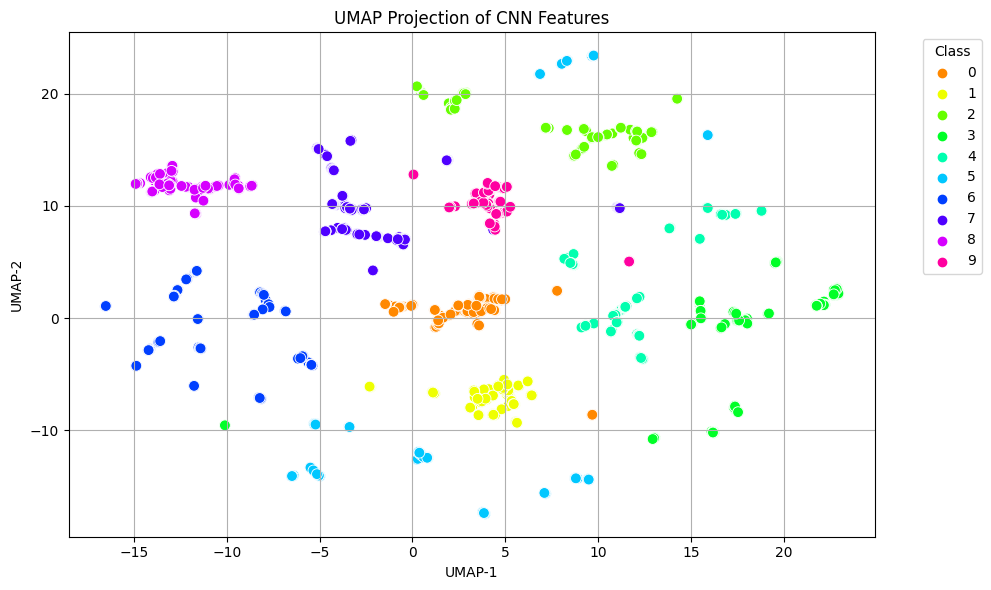

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
palette = sns.color_palette("hsv", np.unique(labels).max() + 1)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette=palette, legend="full", s=60)
plt.title("UMAP Projection of CNN Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def show_predicted_images(model, dataset, num_images=8):
    model.eval()
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    plt.figure(figsize=(16, 6))
    
    for i, idx in enumerate(indices):
        image, true_label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
        
        with torch.no_grad():
            output = model(input_tensor)
            probs = F.softmax(output, dim=1)
            confidence, pred_label = torch.max(probs, 1)
        
        # Plot image
        plt.subplot(2, num_images // 2, i+1)
        img_np = image.permute(1, 2, 0).numpy() if image.shape[0] == 3 else image.squeeze().numpy()
        plt.imshow(img_np, cmap="gray" if image.shape[0] == 1 else None)
        plt.title(f"Pred: {pred_label.item()} ({confidence.item()*100:.2f}%)\nTrue: {true_label}")
        plt.axis("off")
    
    plt.suptitle("Predicted Images with Confidence Scores", fontsize=16)
    plt.tight_layout()
    plt.show()

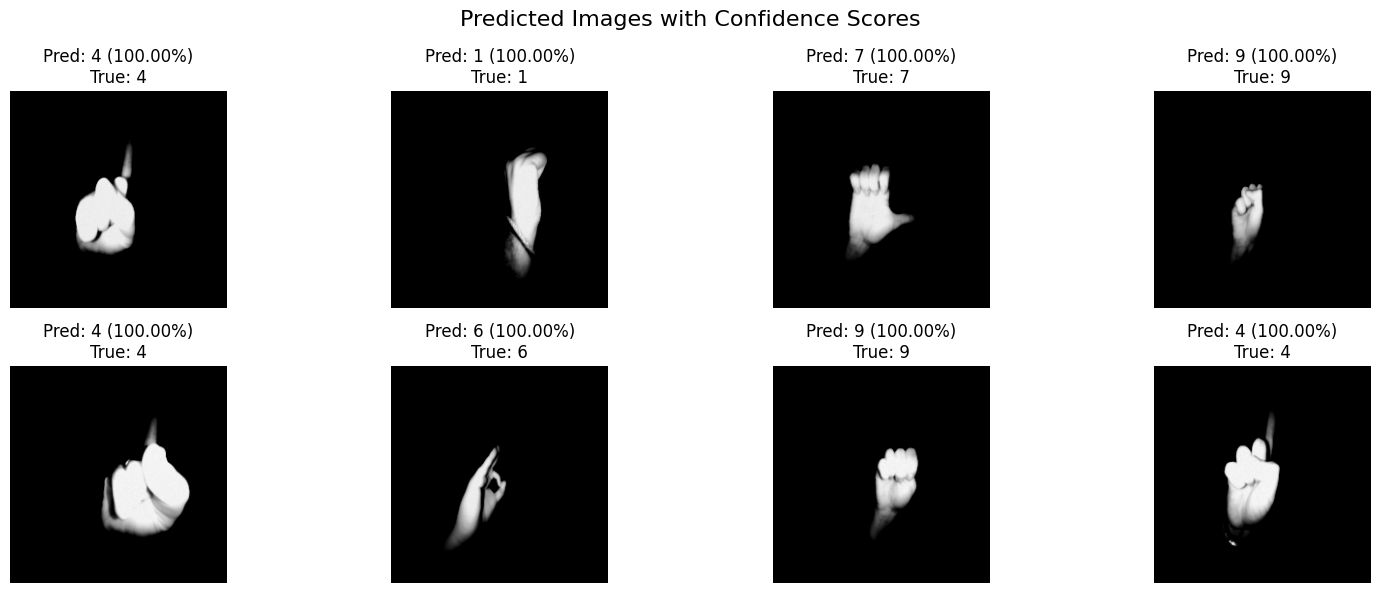

In [27]:
show_predicted_images(model, test_set, num_images=8)